In [2]:
# @title #Install requirements { display-mode: "code" }
!pip install -q --upgrade transformers diffusers ftfy mediapy

from base64 import b64encode

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

import numpy as np
import mediapy as mp
import cv2

from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# @title #Load Models
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", torch_dtype=torch.float16)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
#@title #Generate Images: Alternate denoising of two views
first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain villagee"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.


            if i % 2 == 0:
                latents = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
                latent_model_input = torch.cat([latents] * 2)  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            else:
                latent_model_input = torch.cat([latents] * 2)  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                if i % 2 == 0:
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                else:
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            if i % 2 == 0:
                # apply inverse transformation for the next iteration to have the correct latent and noise_prediction
                noise_pred = torch.rot90(noise_pred, -rotate, [2, 3])
                latents = torch.rot90(latents, -rotate, [2, 3])

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")[0, ...]

    mp.show_images([image, np.rot90(image, rotate, (0, 1))])

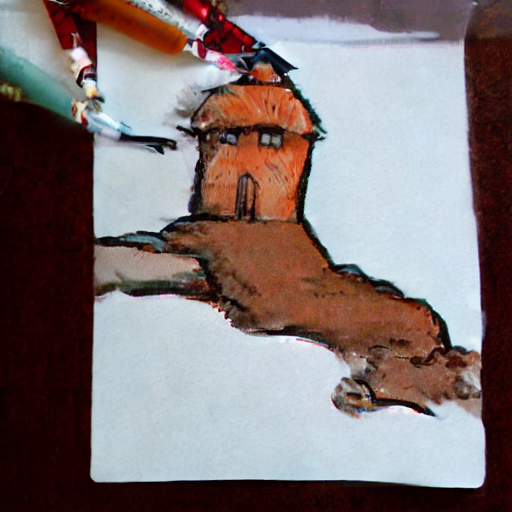

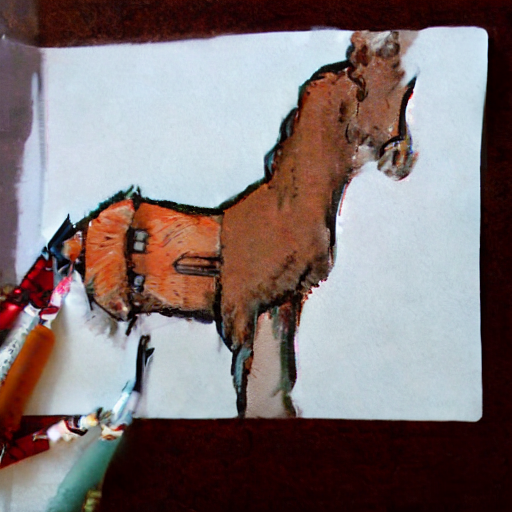

In [ ]:
# Let's visualize the four channels of this latent representation:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latents[0][c].cpu(), cmap='Greys')

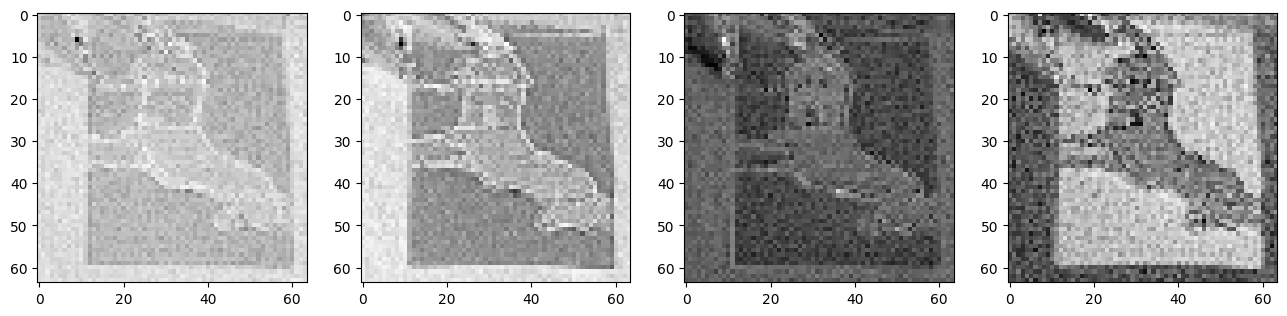

In [50]:
#@title #Generate Images: average the noise of two views, rotation by 90
first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain village"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]



    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample


0


<ipython-input-50-c5c9a9127289>:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

In [ ]:
# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])

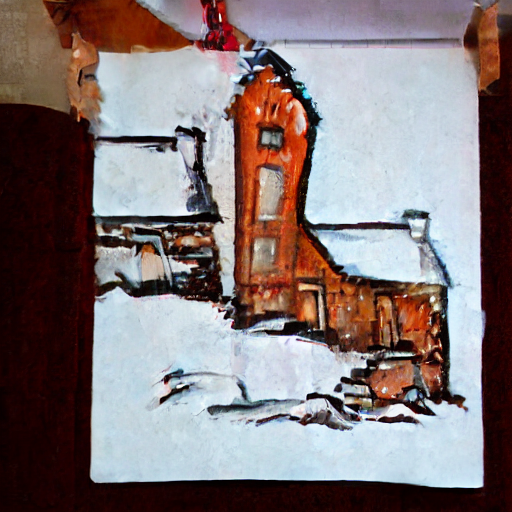

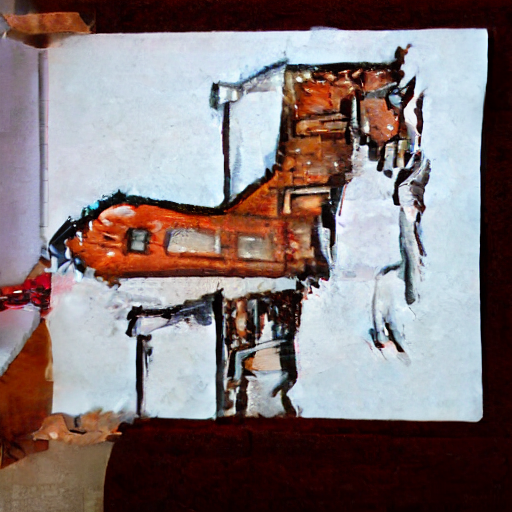

In [ ]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(output_latent[0][c].cpu(), cmap='Greys')

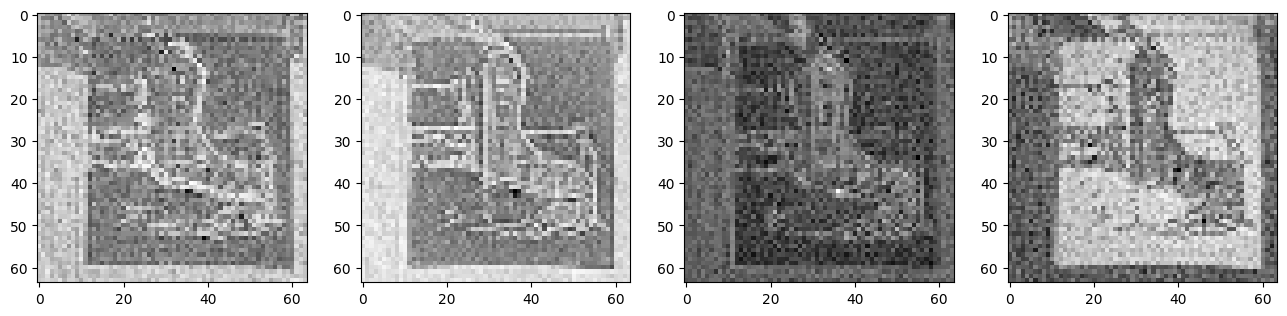

In [58]:
#@title #Generate Images: average the noise of two views, flip
first_prompt = "an oil painting of a red panda"
second_prompt = "an oil painting of kitchenware"
rotation_deg = "180"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]



    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample

0


<ipython-input-58-9012387cdc96>:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

In [ ]:
# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])

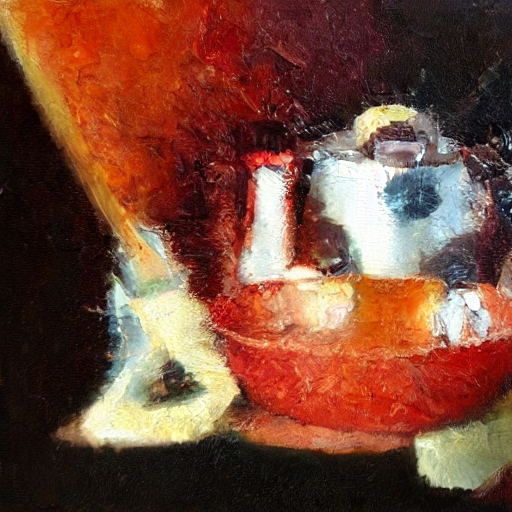

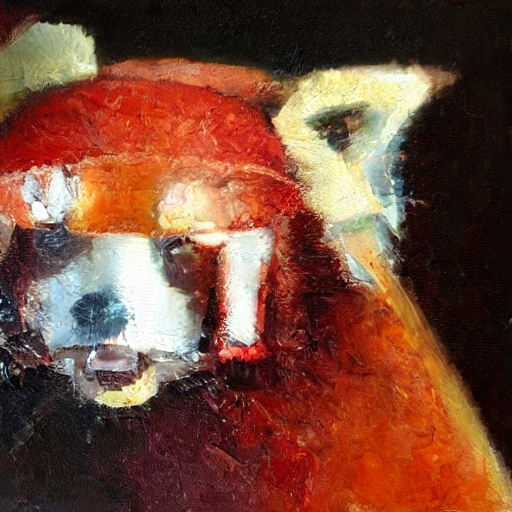

In [ ]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(output_latent[0][c].cpu(), cmap='Greys')

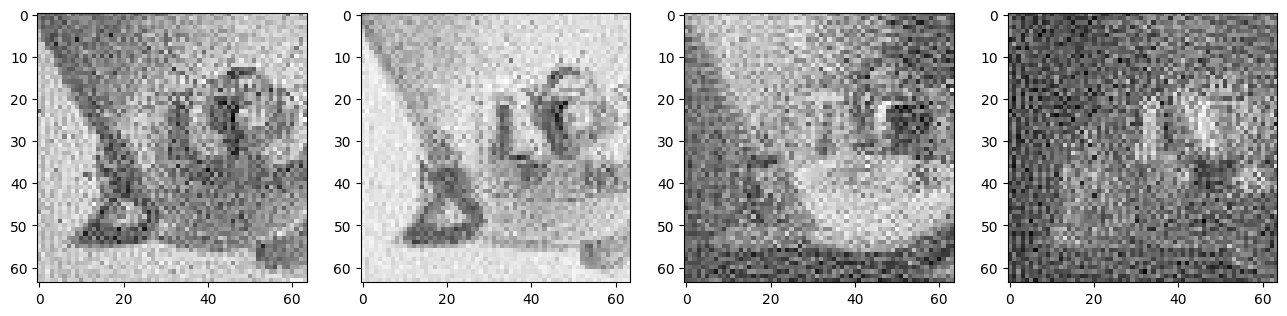